In [1]:
import os
import sys
import pickle
import numpy as np
import pandas as pd
from PIL import Image, ImageFilter
from tqdm import tqdm
from sklearn.preprocessing import StandardScaler,MinMaxScaler
from sklearn.metrics import accuracy_score, mean_squared_error, log_loss, confusion_matrix
import matplotlib.pyplot as plt
import operator
import json
np.random.seed(100)
LEVEL = 'level_4b'

In [2]:
def read_all(folder_path, key_prefix=""):
    '''
    It returns a dictionary with 'file names' as keys and 'flattened image arrays' as values.
    '''
    print("Reading:")
    images = {}
    img_thesh = lambda x : 0 if x >10  else 255
    files = os.listdir(folder_path)
    for i, file_name in tqdm(enumerate(files), total=len(files)):
        file_path = os.path.join(folder_path, file_name)
        image_index = key_prefix + file_name[:-4]
        image = Image.open(file_path)
        image = image.convert("L").point(img_thesh)
        image = image.filter(ImageFilter.MedianFilter)
        images[image_index] = np.array(image.copy()).flatten()
        image.close()
    return images

In [3]:
languages = ['ta', 'hi', 'en']
#trainPath = "../input/padhai-text-non-text-classification-level-1/"+LEVEL+"_train/"+LEVEL+"/"
#testPath = "../input/padhai-text-non-text-classification-level-1/"+LEVEL+"_test/kaggle_"+LEVEL
images_train = read_all("../input/text-non-text-classification-level-4b/level_4b_train/level_4b/"+"background", key_prefix='bgr_') # change the path
for language in languages:
    images_train.update(read_all("../input/text-non-text-classification-level-4b/level_4b_train/level_4b/"+language, key_prefix=language+"_" ))
print(len(images_train))

images_test = read_all("../input/text-non-text-classification-level-4b/level_4b_test/kaggle_level_4b", key_prefix='') # change the path
print(len(images_test))

  0%|          | 0/4500 [00:00<?, ?it/s]

Reading:


  3%|▎         | 39/1500 [00:00<00:03, 385.69it/s]

Reading:


  3%|▎         | 38/1500 [00:00<00:03, 379.13it/s]

Reading:


  2%|▏         | 34/1500 [00:00<00:04, 333.17it/s]

Reading:


  1%|          | 35/3000 [00:00<00:08, 345.78it/s]

9000
Reading:


100%|██████████| 3000/3000 [00:08<00:00, 340.43it/s]

3000


In [4]:
! cd ../input

In [5]:
list(images_test.keys())[:5]

['919', '1357', '795', '84', '2520']

In [6]:
X_train = []
Y_train = []

for key, value in images_train.items():
    X_train.append(value)
    if key[:4] == "bgr_":
        Y_train.append(0)
    else:
        Y_train.append(1)

ID_test = []
X_test = []
for key, value in images_test.items():
    ID_test.append(int(key))
    X_test.append(value)

X_train = np.array(X_train)
Y_train = np.array(Y_train)
X_test = np.array(X_test)

print(X_train.shape, Y_train.shape)
print(X_test.shape)

(9000, 4096) (9000,)
(3000, 4096)


In [7]:
scaler = MinMaxScaler()
X_scaled_train = scaler.fit_transform(X_train)
X_scaled_test = scaler.transform(X_test)

In [8]:
X_train_binarized = []
for i in X_train:
    i = list(i)
    x = [0 if y == 255 else 1 for y in i]
    X_train_binarized.append(np.array(x))

X_test_binarized = []
for i in X_test:
    i = list(i)
    x = [0 if y == 255 else 1 for y in i]
    X_test_binarized.append(np.array(x))

X_train_binarized = np.array(X_train_binarized)
X_test_binarized = np.array(X_test_binarized)

In [9]:
class MPNeuron:
    
    def __init__(self):
        self.theta = None
        
    def mp_neuron(self, x):
        if sum(x) >= self.theta:
            return 1
        return 0
    
    def fit_brute_force(self, X, Y):
        accuracy = {}
        for theta in tqdm(range(0, X.shape[1]+1), total=X.shape[1]+1):
            self.theta = theta
            Y_pred = self.predict(X)
            accuracy[theta] = accuracy_score(Y, Y_pred)  
            
        sorted_accuracy = sorted(accuracy.items(), key=operator.itemgetter(1), reverse=True)
        best_theta, best_accuracy = sorted_accuracy[0]
        self.theta = best_theta
        
    def fit(self, X, Y, epochs=10, log=False, display_plot=False):
        self.theta = (X.shape[1]+1)//2
        if log or display_plot:
            accuracy = {}
        for i in tqdm(range(epochs), total=epochs, unit="epoch"):
            Y_pred = self.predict(X)
            tn, fp, fn, tp = confusion_matrix(Y, Y_pred).ravel()
            if fp > fn and self.theta <= X.shape[1]:
                self.theta += 1
            elif fp < fn and self.theta >= 1:
                self.theta -= 1
            else:
                continue
                
            if log or display_plot:
                Y_pred = self.predict(X)
                accuracy[i] = accuracy_score(Y, Y_pred)
        if log:
            with open('mp_neuron_accuracy.json', 'w') as fp:
                json.dump(accuracy, fp)
        if display_plot:
            epochs_, accuracy_ = zip(*accuracy.items())
            plt.plot(epochs_, accuracy_)
            plt.xlabel("Epochs")
            plt.ylabel("Train Accuracy")
            plt.show()
    
    def predict(self, X):
        Y = []
        for x in X:
            result = self.mp_neuron(x)
            Y.append(result)
        return np.array(Y)


class Perceptron:
    
    def __init__(self):
        self.w = None
        self.b = None
        
    def perceptron(self, x):
        return np.sum(self.w * x) + self.b
    
    def fit(self, X, Y, epochs=10, learning_rate=0.01, log=False, display_plot=False):
        # initialise the weights and bias
        self.w = np.random.randn(1, X.shape[1])
        self.b = 0
        if log or display_plot: 
            accuracy = {}
        for i in tqdm(range(epochs), total=epochs, unit="epoch"):
            for x, y in zip(X, Y):
                result = self.perceptron(x)
                if y == 1 and result < 0:
                    self.w += learning_rate*x
                    self.b += learning_rate
                elif y == 0 and result >= 0:
                    self.w -= learning_rate*x
                    self.b -= learning_rate
            if log or display_plot:
                Y_pred = self.predict(X)
                accuracy[i] = accuracy_score(Y, Y_pred)
        if log:
            with open('perceptron_accuracy.json', 'w') as fp:
                json.dump(accuracy, fp)
        if display_plot:
            epochs_, accuracy_ = zip(*accuracy.items())
            plt.plot(epochs_, accuracy_)
            plt.xlabel("Epochs")
            plt.ylabel("Train Accuracy")
            plt.show()
                    
    def predict(self, X):
        Y = []
        for x in X:
            result = self.perceptron(x)
            Y.append(int(result>=0))
        return np.array(Y)


class PerceptronWithSigmoid:
    
    def __init__(self):
        self.w = None
        self.b = None
        
    def perceptron(self, x):
        return np.sum(self.w * x) + self.b
    
    def sigmoid(self, z):
        return 1. / (1. + np.exp(-z))
    
    def grad_w(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
    
    def grad_b(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)
    
    def fit(self, X, Y, epochs=10, learning_rate=0.01, log=False, display_plot=False):
        # initialise the weights and bias
        self.w = np.random.randn(1, X.shape[1])
        self.b = 0
        if log or display_plot: 
            #accuracy = {}
            mse = {}
        for i in tqdm(range(epochs), total=epochs, unit="epoch"):
            dw, db = 0, 0
            for x, y in zip(X, Y):
                dw += self.grad_w(x, y)
                db += self.grad_b(x, y)
            self.w -= learning_rate*dw
            self.b -= learning_rate*db
            
            if log or display_plot:
                Y_pred = self.predict(X)
                #Y_binarized = (Y >= SCALED_THRESHOLD).astype(np.int)
                #Y_pred_binarized = (Y_pred >= SCALED_THRESHOLD).astype(np.int)
                #accuracy[i] = accuracy_score(Y_binarized, Y_pred_binarized)
                mse[i] = mean_squared_error(Y, Y_pred)
        if log:
            #with open('perceptron_with_sigmoid_accuracy.json', 'w') as fp:
                #json.dump(accuracy, fp)
            with open('perceptron_with_sigmoid_mse.json', 'w') as fp:
                json.dump(mse, fp)
        if display_plot:
            #epochs_, accuracy_ = zip(*accuracy.items())
            #plt.plot(epochs_, accuracy_)
            #plt.xlabel("Epochs")
            #plt.ylabel("Train Accuracy")
            #plt.show()
            epochs_, mse_ = zip(*mse.items())
            plt.plot(epochs_, mse_)
            plt.xlabel("Epochs")
            plt.ylabel("Train Error (MSE)")
            plt.show()
            
                    
    def predict(self, X):
        Y = []
        for x in X:
            result = self.sigmoid(self.perceptron(x))
            Y.append(result)
        return np.array(Y)

In [10]:
class SigmoidNeuron:
    def __init__(self):
        self.w = None
        self.b = None
    
    def perceptron(self, x):
        return np.dot(x, self.w.T) + self.b
  
    def sigmoid(self, x):
        return 1.0/(1.0 + np.exp(-x))
  
    def grad_w_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred) * x
  
    def grad_b_mse(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        return (y_pred - y) * y_pred * (1 - y_pred)
  
    def grad_w_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        if y == 0:
            return y_pred * x
        elif y == 1:
            return -1 * (1 - y_pred) * x
        else:
            raise ValueError("y should be 0 or 1")
    
    def grad_b_ce(self, x, y):
        y_pred = self.sigmoid(self.perceptron(x))
        if y == 0:
            return y_pred 
        elif y == 1:
            return -1 * (1 - y_pred)
        else:
            raise ValueError("y should be 0 or 1")
  
    def fit(self, X, Y, epochs=1, learning_rate=1, initialise=True, loss_fn="mse", display_loss=False): 
        
        # initialise w, b
        if initialise:
             #self.w = np.random.randn(1, X.shape[1])
            self.w = X.mean(axis=0)
            self.b = 0
      
        if display_loss:
            loss = {}
    

        for i in tqdm(range(epochs), total=epochs, unit="epoch"):
            
        #for i in range(epochs):
        #while (condition):        
            dw = 0
            db = 0
        
            for x, y in zip(X, Y):
                if loss_fn == "mse":
                    dw += self.grad_w_mse(x, y)
                    db += self.grad_b_mse(x, y) 
                    self.w -= learning_rate * dw
                    self.b -= learning_rate * db
                elif loss_fn == "ce":
                    dw += self.grad_w_ce(x, y)
                    db += self.grad_b_ce(x, y)
                    self.w -= learning_rate * dw
                    self.b -= learning_rate * db
      
            if display_loss:
                Y_pred = self.sigmoid(self.perceptron(X))
                if loss_fn == "mse":
                    loss[i] = mean_squared_error(Y, Y_pred)
                    flag = loss[i]
                elif loss_fn == "ce":
                    loss[i] = log_loss(Y, Y_pred)
                    flag = loss[i]
            

        if display_loss:
            plt.plot(np.array(list(loss.values())).astype(float))
            plt.xlabel('Epochs')
            if loss_fn == "mse":
                plt.ylabel('Mean Squared Error')
            elif loss_fn == "ce":
                plt.ylabel('Log Loss')
            plt.show()
    
            min_key = min(loss, key=loss.get)
            print(min_key)
            print(loss.get(min_key))
            print(i)
       
    def predict(self, X):
        Y_pred = []
        for x in X:
            y_pred = self.sigmoid(self.perceptron(x))
            Y_pred.append(y_pred)
        return np.array(Y_pred)

In [11]:
#mp = MPNeuron()
#mp.fit(X_train_binarized, Y_train, epochs=30, log = False, display_plot=True)
def print_accuracy(sn):
    Y_pred_train = sn.predict(X_train_binarized)
    accuracy_train = accuracy_score(Y_pred_train, Y_train)   
    print("Train Accuracy : ", accuracy_train)
    print("-"*50)
#print_accuracy(mp)

In [12]:
#per = Perceptron()
#per.fit(X_scaled_train, Y_train, epochs=100,learning_rate=0.0021, log=False, display_plot=True)

In [13]:
#per_sig = PerceptronWithSigmoid()
#per_sig.fit(X_scaled_train,Y_train,epochs=100,learning_rate=0.0025, log=False, display_plot=True)

  0%|          | 0/100 [00:00<?, ?epoch/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
  1%|          | 1/100 [00:00<00:50,  1.94epoch/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
  2%|▏         | 2/100 [00:01<00:50,  1.93epoch/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
  3%|▎         | 3/100 [00:01<00:50,  1.93epoch/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
  4%|▍         | 4/100 [00:02<00:49,  1.92epoch/s]/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in e

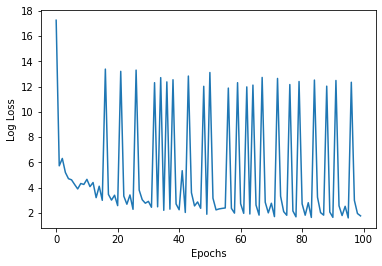

95
1.5927776915770369
99


In [14]:
sn_ce = SigmoidNeuron()
sn_ce.fit(X_scaled_train, Y_train, epochs=100, learning_rate=0.015,initialise=True,loss_fn="ce",display_loss=True)

In [15]:
def print_accuracy(sn):
    Y_pred_train = sn.predict(X_scaled_train)
    Y_pred_binarised_train = (Y_pred_train >= 0.5).astype("int").ravel()
    accuracy_train = accuracy_score(Y_pred_binarised_train, Y_train)
    #accuracy_train = accuracy_score(Y_pred_train, Y_train)   
    print("Train Accuracy : ", accuracy_train)
    print("-"*50)

In [16]:
print_accuracy(sn_ce)

Train Accuracy :  0.9491111111111111
--------------------------------------------------


/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.


In [17]:
Y_pred_test = sn_ce.predict(X_scaled_test)
Y_pred_binarised_test = (Y_pred_test >= 0.5).astype("int").ravel()
submission = {}
submission['ImageId'] = ID_test
submission['Class'] = Y_pred_binarised_test

submission = pd.DataFrame(submission)
submission = submission[['ImageId', 'Class']]
submission = submission.sort_values(['ImageId'])
submission.to_csv("submission.csv", index=False)

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:10: RuntimeWarning: overflow encountered in exp
  # Remove the CWD from sys.path while we load stuff.
